In [1]:
from jupyter_helpers.selective_import import notebooks_importer 
from Data import clinical, raw_protein_matrix, protein_levels

Importing Jupyter notebook from Data.ipynb


In [2]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [3]:
%R source('plots/colors.R');

In [4]:
# note: this is already limitted to the patients having the protein measurments
by_condition = clinical.Meningitis

In [5]:
%%R -i raw_protein_matrix -i by_condition
import::here(space_to_dot, dot_to_space, .from='helpers/utilities.R')
import::here(
    design_from_conditions, calculate_means, limma_fit,
    .from='helpers/differential_expression.R'
)

### Notes on the data nature

Based on a discussion during the last April meeting: 
- During the study there were 186 admissions of meningitis patients in the study hospital. It is likely that many of the severe patients were not enrolled in the study, as it was not the priority of the clinician to ask for consent (or it would be impossible).
  - this might impact survival estimates, i.e. we may be missing some of the very severe patients who died too early for the necessary consents and biofluids to be collected
- Missing protein data → to little CSF, they need to decide whether these will be used to CSF or RNAseq. This may be random-like decision.

## Preprocessing

### Log transformation

The log-transform is (among others) assumed to:
- improve normality of skewed data - often sought when required by parametric tests; noteworthy is the fact that usually the normality of errors is sufficient [ref]),
- stabilize the variance - desired in PCA analysis to counterbalance the mean-variance trends (please see the "mean-variance relationship section for more detailed discussion) or in the differential expression methods which assume normality [(Law, 2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4053721/), such as *limma*.

However, as demonstrated by [(Feng et al, 2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/) the log-transformation often does not lead to realization of these assumptions, and caution is advised to researchers who decide to use any data transformation (instead of choosing more advanced methods or non-parametric tests).

Because the chosen statistical package *limma* expects the input to be log-transformed intensities (for microarray data) or log-transformed RNA counts (for RNA-seq) and SOMAScan protocols where not previously evaluated, I will:
- employ the log-transformation in the main analysis (to conform to the limmas expectations)
- evaluate use of non-transformed data (as a side task) as I assume that these would capture the view of the data from a different angle
- try to explain the differences by manual comparison of the top and bottom proteins highlighted these preprocessing methods

In [6]:
from numpy import log2, log, log10

transformations = {
    'not-transformed': lambda x: x,
    'log-transformed': log10
}

#### On the improved normality

While I demonstrated in the unsupervised analysis notebook that log-transform does not make the protein abundances normally distributed, I also noted that the skewness of the distributions decreased, alleviating the outliers impact.

Here I confirm these observations using more through testing:

In [7]:
from scipy.stats import kurtosis, skew

I investigate skew and kurtosis of protein distributions. The normal distributions has skew and kurtosis equal to 0.

I will look at two distributions:
 - patient-to-patient distributions (distributions of levels protein abundances across the patients; protein=fixed)
    - I also limit the analyzed subset to the healthy patients to simplify the interpretation
 - protein-to-protein distribution (distribution of protein abundances in each of the patients; patient=fixed)
    - this is not trivial in interpretation as selection of proteins in this formulation is not a random process; however, it is beneficial to show reduced skew of this distribution as it represents reduced impact of outliers

In the very specific context of gene expression [(Beal, 2017)](https://ieeexplore.ieee.org/abstract/document/7991639) notes that the log-normal  (cell-to-cell) distribution of gene levels is expected due to the nature of the expression process*. However, our study faces a more complex situation, where proteins from very different types of cells may be mixed up in the CSF (for equivalent, patient-to-patient distribution). 

*) which is a product of many subprocesses assumed to be random variables with non-negative values; by the Gibrat's law - an extension of central limit theorem - a product of these these will lead to a log-normal distribution

In [8]:
def stack_observations(by_group):
    by_observation = by_group.stack().reset_index()
    by_observation.columns = ['observation', 'group', 'value']
    by_observation.group = pd.Categorical(by_observation.group, ordered=True, categories=transformations.keys())
    return by_observation

def measure_by_transform(data, measure):
    return DataFrame({
        name: measure(transform(data))
        for name, transform in transformations.items()
    })

Since the observations are paired (by protein or patient) I use paired t-test:

In [9]:
from scipy.stats import ttest_rel

I show that both skew and kurtosis decrease (and thus approach zero) when using the log-transform:

In [10]:
hc = by_condition[by_condition=='Healthy control'].index

distributions = {
    'patient-to-patient': raw_protein_matrix.T,
    'patient-to-patient (healthy controls only)': raw_protein_matrix[hc].T,
    'protein-to-protein': raw_protein_matrix,
}

test_results = []
measurements = []

for measure in [skew, kurtosis]:
    for name, observations in distributions.items():
        df = measure_by_transform(observations, measure)
        measurements.append(
            stack_observations(df).assign(measure=measure.__name__, distribution=name)
        )
        result = ttest_rel(df['not-transformed'], df['log-transformed'])
        test_results.append(dict(
            measure=measure.__name__, distribution=name,
            p=result.pvalue, statistic=result.statistic, 
        ))

test_results = DataFrame(test_results)
measurements = concat(measurements)

In [11]:
test_results['label'] = test_results.apply(lambda x: f'p = {x.p:.2e}\nt = {x.statistic:.2f}', axis=1)

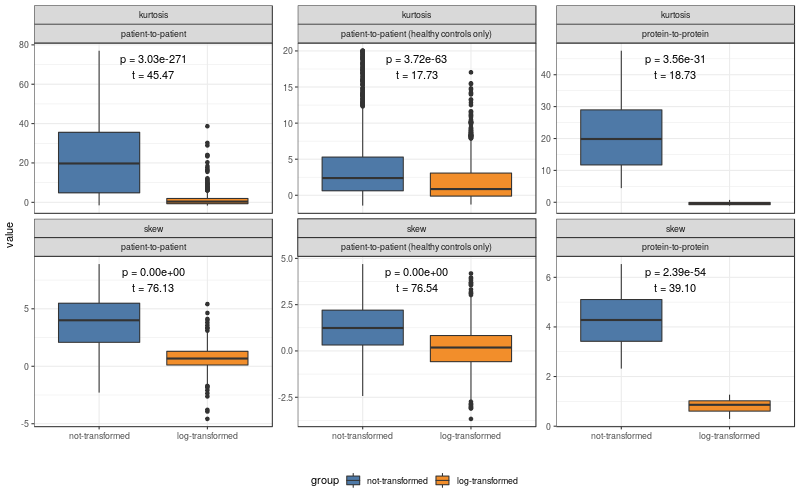

In [12]:
%%R -i measurements -i test_results -w 800 -h 500
(
    ggplot(measurements, aes(y=value, x=group))
    + geom_boxplot(aes(fill=group))
    + theme_bw()
    + facet_wrap('measure ~ distribution', scale='free_y') + xlab('')
    + theme(legend.position='bottom')
    + geom_text(data=test_results, aes(label=label, y=Inf, x=1.5), vjust=1.5)
    + ggthemes::scale_fill_tableau()
)

In any case, the log-transformation does move our data closer to the normal distribution.

#### On the benefit for variance stabilization

In [13]:
matrices = {
    name: transform(raw_protein_matrix)
    for name, transform in transformations.items()
}

In [14]:
mean_vs_variance = concat([
    DataFrame(dict(
        variance=data.var(axis=1),
        residual_variance=data.var(axis=1) - data.mean(axis=1), 
        mean_abundance=data.mean(axis=1),
        rank_of_mean_abundance=data.mean(axis=1).rank(),
        group=group
    ))
    for group, data in matrices.items() 
])
mean_vs_variance.group = pd.Categorical(mean_vs_variance.group, ordered=True, categories=matrices.keys())

The log-transformed data indeed presents lower variance with reduced (but not eliminated) mean-variance trend (**which will be important for selection of *limma* parameters**):

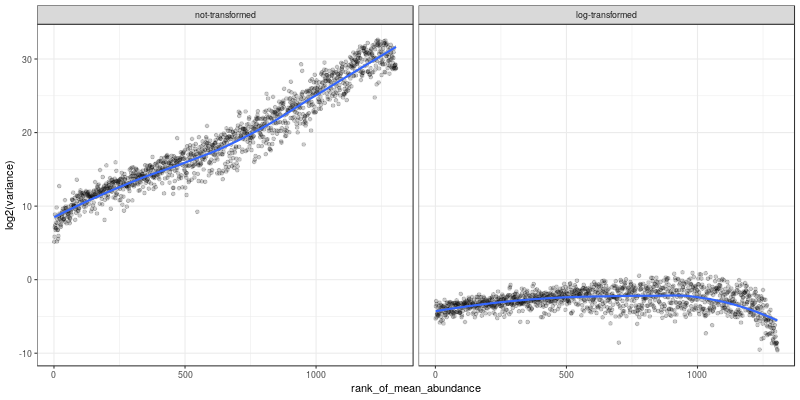

In [15]:
%%R -i mean_vs_variance -w 800 -h 400 -u px
(
    ggplot(mean_vs_variance, aes(x=rank_of_mean_abundance, y=log2(variance)))
    + geom_point(alpha=0.2)
    + stat_smooth(method='loess')
    + facet_wrap('group')
    + theme_bw()
)

### On the mean-variance relation (in detail)

#### Why we want to suppress the mean-variance trend?

**For PCA:**
- if the trend is positive (the higher the mean intensity, the higher the variance) the first PCA components would capture very few, outlying and highly abundant proteins which are usually either well-known or easily identifiable by simpler means (and missing the signal from many more interesting proteins which are as important, but of lower abundance) - unless the variance stabilization is performed
- however if the inverse is true (which may be the case for RNA-seq data - see below), the proteins which may not be expressed/present in most samples would inflate the fold change and possibly drive substantial amount of the principal components.

**For differential expression analysis:**
- limma assumes normality (Law, 2014) thus greatly unequal variances are an obstacle to application of this method to data sources such as RNA-seq counts [(Law et al, 2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4053721/).
- it was shown that modeling the mean-variance relation and using it as a prior for Bayesian model improves the results of both RNA-seq [(Law et al, 2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4053721/) and microarray [(Sartor et al, 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1781470/#__sec5title) DE analysis.
- the SOMAScan data present unique challenges having characteristics of both microarray and RNA-seq data:
  - the final abundance measurement is based on the light intensity, being essentially a DNA microarray
  - the high dynamic range is as high (and even higher) than in RNA-seq

Our effective values range:

In [16]:
f'{raw_protein_matrix.max().max() / raw_protein_matrix.min().min():.2e}'

'3.03e+05'

#### What is the expected mean-variance relationship?

The relation between mean abundance and variance will depend on the interplay of biological and technical variation [(Law et al, 2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4053721/), (EdgeR Users Manual) and the technique (RNA-seq, microarray, SOMAScan).
- microarrays: [(Sartor et al, 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1781470/#__sec5title) argue that it is natural to expect the decreasing trend (they operate on log-transformed data!),
  > Spots with low fluorescence level will likely have fewer pixels measured*, and the resulting estimate of expression is an average or median of fewer or lower numbers. Furthermore, transcripts that are lowly expressed are changed by a greater proportion by the addition of a few labeled transcripts, and thus may actually vary more in biological tissue samples. [(Sartor et al, 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1781470/#__sec5title)

- RNA-seq: the technical variance in counts is assumed to decrease with the number of counts due to the analogous argument as the proportion of labeled transcripts for microarrays: when we are at a level of single counts, each next fragment captured will significantly change the value, whilst the one fragment more or less will not matter for high abundance proteins) thus the higher the abundance of transcripts, the more biological variation these are assumed to represent (Law et al, 2014)
  - by the way: for count-based data (RNA-seq), one approach is to model the biological variation by negative binomial distribution (used in EdgeR)
   
Some articles present the positive relation between mean expression and variance - e.g. [(Subramaniam and Hsiao, 2012)](https://www.nature.com/articles/ni.2244) - for both microarray and RNA-seq data. However, these do not use the log-transformation and as I demonstrate below this relation changes drastically when the log-transformation is applied, and as discussed by (Sartor et al, 2006) may lead to an exaggeration of the adjustment (changing the direction of the relation for the high-abundance proteins).

What can be deduced from (Sartor et al, 2006), the use of a mean-variance modeling for DE analysis is beneficial regardless of use of the log-transformation.

*) I do not understand this argument

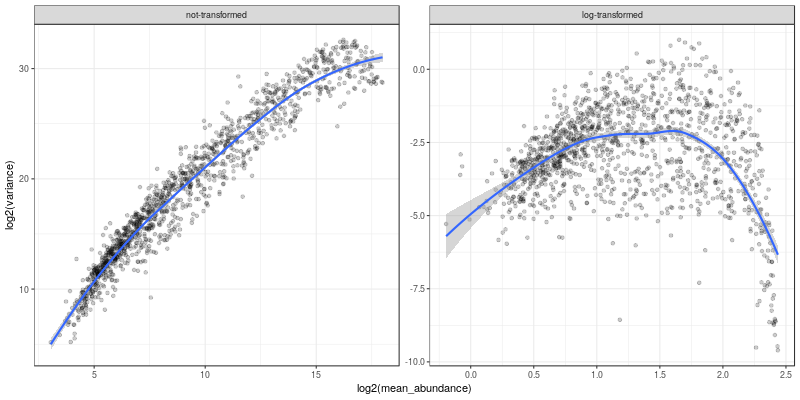

In [17]:
%%R -w 800 -h 400 -u px
(
    ggplot(mean_vs_variance, aes(x=log2(mean_abundance), y=log2(variance)))
    + geom_point(alpha=0.2)
    + stat_smooth(method='loess')
    + facet_wrap('group', scale='free')
    + theme_bw()
)

Note: without the log(mean), the non-transformed facet is illegible. The log-transformed facet is only slightly affected.

### Removing proteins with too low abundance (across all samples)

#### Why to filter out proteins with low abundance across samples?

For example, to reduce the number of tests which would be deemed to fail (and would be deflating the FDR-corrected p-values; there is a [statquest](https://www.youtube.com/watch?v=Gi0JdrxRq5s) on that); however this is not as crucial for SOMAScan as it would be RNA-seq as the number of measured proteins is only about 1000.


#### How to select the threshold?

We can use the mean of values for all participants to determine threshold for protein cut-off (as described in the limma manual, chapter 7, "Filtering unexpressed probes"). note: we do not have the values for control (background) probes which would make things easier.

In [18]:
%%R
mean_abundance_levels = rowMeans(log10(raw_protein_matrix))
head(mean_abundance_levels)

    CHIP    CEBPB      NSE    PIAS4 IL-10 Ra    STAT3 
1.673366 1.420196 4.007819 1.387390 2.049699 2.811419 


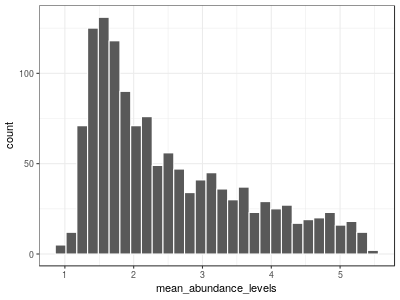

In [19]:
%%R -w 400 -h 300
ggplot(as.data.frame(mean_abundance_levels), aes(x=mean_abundance_levels)) + geom_histogram(color='white') + theme_bw()

If we assume that a low number of proteins is not detectable (or that we only want to remove a small fraction), the very low number of proteins with mean log-abundance below 1 suggests a possible, simple threshold.

Looking at the mean-variance relationship may provide additional benefit, as low variance will highlight the proteins with low abundances consistently across samples:

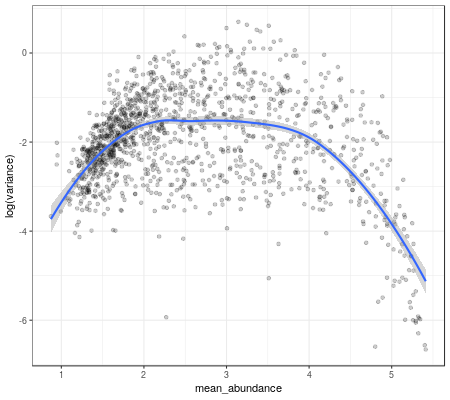

In [20]:
%%R -w 450 -h 400 -u px
df = mean_vs_variance[mean_vs_variance$group=='log-transformed',]
(
    ggplot(df, aes(x=mean_abundance, y=log(variance)))
    + geom_point(alpha=0.2)
    + stat_smooth(method='loess')
    + theme_bw()
)

I adapted the plot above for comparison to the plot generated by limma's built-in diagnostic function "plotSA", which operates on a square root of residual standard deviation:

In [21]:
%%R
design = design_from_conditions(by_condition, intercept=F)
fit = calculate_means(log10(raw_protein_matrix), design)

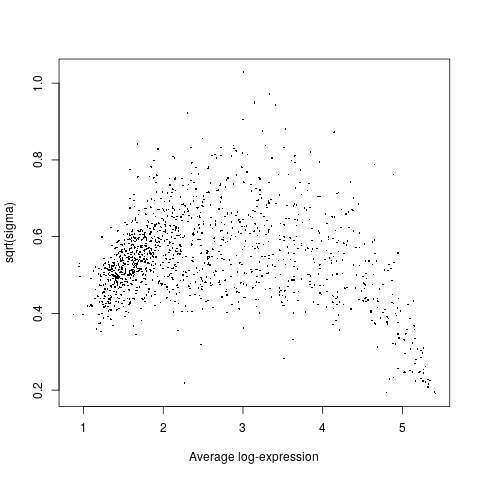

In [22]:
%%R -o fit
limma::plotSA(fit)

The log-expression of 2 appears to be the upper limit for the cut-off as above this value, the variance stabilizes quickly.

To be on the safe side, I only remove the proteins with the average log-abundance <= 1:

In [23]:
protein_matrix = raw_protein_matrix.apply(log10)
should_stay = protein_matrix.mean(axis=1) > 1
removed = protein_matrix[~should_stay]
protein_matrix = protein_matrix[should_stay]
removed

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
target,,,,,,,,,,,
CTLA-4,0.792392,1.220108,0.819544,0.982271,0.863323,...,0.832509,0.785330,0.698970,0.716003,0.857332
IFN-aA,0.806180,1.195900,0.934498,1.577492,0.857332,...,0.845098,0.690196,0.724276,0.755875,0.880814
RSK-like protein kinase,1.262451,1.680336,1.037426,1.503791,0.949390,...,0.740363,0.579784,0.623249,0.591065,0.748188
Neurotrophin-3,0.944483,1.198657,0.973128,1.075547,0.819544,...,0.949390,0.875061,0.863323,0.892095,0.954243
FER,1.041393,1.305351,1.152288,1.437751,1.075547,...,0.724276,0.770852,0.740363,0.653213,0.755875


In [24]:
%%R -i by_condition -i protein_matrix

limma_protein_fit = function(data=protein_matrix, ...) {
    limma_fit(data=data, conditions_vector=by_condition, ...)
}

## Differential levels of proteins

The outputs will be stored in:

In [25]:
from helpers.paths import make_directories

make_directories(
    {'preliminary_analyses': ['differential_protein_levels']},
    root='data'
)

In [26]:
path = 'data/preliminary_analyses/differential_protein_levels/'

### Limma's overview

I use limmas linear model fitting (lmFit) followed by empirical Bayesian method (eBayes):
1. The linear regression is tasked with estimating the condition-dependent (between group, explained) variance (or separating out the random (within-group, unexplained) variance).
2. eBayes is used to "moderate  the  standard  errors  of  the  estimated  log-fold  changes" (which was reported to increase power, stabilize inference and be especially beneficial for low number of arrays - in our case plates/replicates) [(limma's User Guide, Chapter 8)](https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf):
 - the F-statistics is an overall statistic based on multiple t-tests, but
 - it uses information from other samples to improve the standard error estimate  (limma's User Guide, Chapter 13.1)
 - unequal variances between groups are not really a big concern (https://support.bioconductor.org/p/67984/#67987), as the underlying t-tests are robust to unequal variance. However, one could adjust for the variance differences to increase power (using arrayWeights). Please see "variance by patient" plot in [Protein_data_unsupervised_analysis.ipynb](../data_exploration/Protein_data_unsupervised_analysis.ipynb) - we do have a clustering of variance by classes (diseases) but these are not as bad as one could see in cancer data 
 - it can account for outliers by using a robust procedures (robust=T) by trimming the distributions (and thus excluding the effect of outliers)
 - it can use the average log2-intensity (here: abundance, though it is measured by intensity as well) for each gene as a prior (instead of a constant) for the variance.

#### Notes:
- as shown on the mean log-abundance vs variance plots above, the log-transformation stabilizes the variance, however does not eliminate the abundance-variance trend completely. Thus use of trend=T is warranted
- log2 appears to be preferred as it is easier to interpret. Should I change it? Maybe not as here we have much bigger changes?
- I could explore TMM normalization as an alternative to log-transformation as it is somehow recommended in the limma's user guide (p. 71), however in the specific context of RNA-seq (which might not stand for SOMAScan)
- one might prefer to use `voom` over `eBayes` with `trend=T`, but because the library sizes are equal for SOMAScan, this should not change the results greatly.

## Indirect comparison (vs healthy controls)

### Venn diagrams

i.e. shared proteins with reduced or increased abundance characterize similarities of meningitis subtypes

I will look at both up and down proteins first. The number in the bottom right of Venn diagrams represents count (or percent) of proteins without significantly changed abundances in any of the conditions.

Here is a simple approach using manually specified contrasts for a design without intercept:

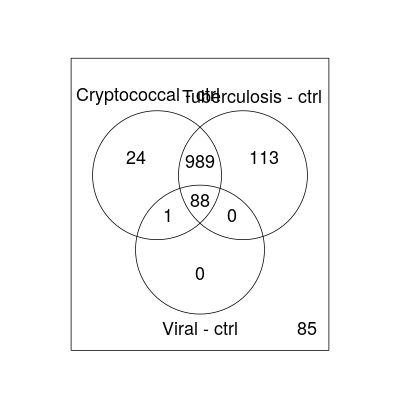

In [27]:
%%R -h 400 -w 400
design = design_from_conditions(by_condition, intercept=F)
fit = calculate_means(protein_matrix, design)

contrast.matrix <- limma::makeContrasts(
    Cryptococcal-Healthy.control,
    Tuberculosis-Healthy.control,
    Viral-Healthy.control,
    levels=design
)
diff_fit <- limma::contrasts.fit(fit, contrast.matrix)
diff_fit = limma::eBayes(diff_fit, trend=T, robust=T)

# limma::decideTests returns:
#   +1 for significantly positive,
#   -1 for significantly negative, and
#   0 for non-significant proteins
r = limma::decideTests(diff_fit, adjust.method="BH", p.value=0.05)
colnames(r) = gsub('Healthy control', 'ctrl', dot_to_space(colnames(r)))

limma::vennDiagram(r)

Equivalent approach, using a design with intercept (as a sanity test + easier to colorize):

In [28]:
%%R
venn_abundance = function(data, groups, intercept='Healthy.control', percentage=F, ...){
    design = design_from_conditions(groups, intercept='Healthy.control')
    fit = calculate_means(data, design)
    
    contrast.matrix <- limma::makeContrasts(
        Cryptococcal, Tuberculosis, Viral,
        levels=design
    )
    diff_fit <- limma::contrasts.fit(fit, contrast.matrix)
    diff_fit = limma::eBayes(diff_fit, trend=T, robust=T)

    r = limma::decideTests(diff_fit, adjust.method="BH", p.value=0.05)
    colnames(r) = dot_to_space(colnames(r))
    
    if(percentage) {
        proteins_analyzed = nrow(raw_protein_matrix)
        counts = limma::vennCounts(r)
        percentage = as.character(round(counts[,'Counts'] / proteins_analyzed * 100, digits=1))
        counts[,'Counts'] = paste(percentage, '%', sep='')
        limma::vennDiagram(counts, circle.col=patient_colors$Meningitis[colnames(r)], ...)
    }
    else {
        limma::vennDiagram(r, circle.col=patient_colors$Meningitis[colnames(r)], mar=c(0,0,1,0), ...)
    }
}

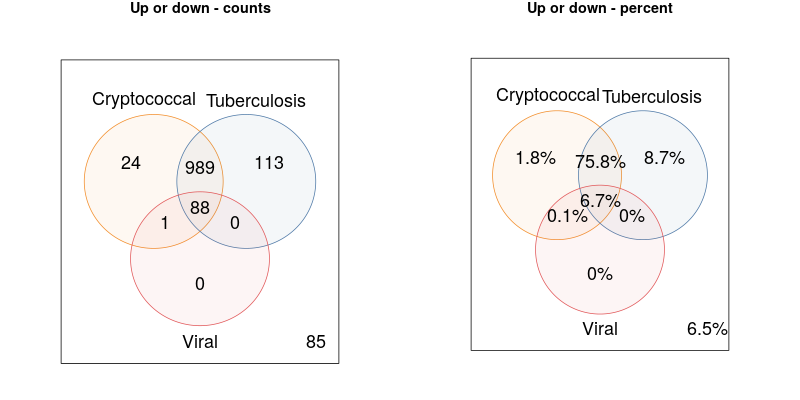

In [29]:
%%R -w 800 -h 400
par(mfrow=c(1, 2))
venn_abundance(protein_matrix, by_condition, percentage=F, main='Up or down - counts')
venn_abundance(protein_matrix, by_condition, percentage=T, main='Up or down - percent')

It seems that we should be able to find nice biomarkers characteristic to TBM. For the viral we have only a few patients which may explain the low number of significantly different protein levels:

In [30]:
by_condition.value_counts()

Tuberculosis       26
Healthy control    25
Cryptococcal       24
Viral               7
Name: Meningitis, dtype: int64

Importantly, the fraction of proteins significantly changed in the crypto and TB is very high. This was expected given previous analyses.

And here is an equivalent for non-transformed data matrix:

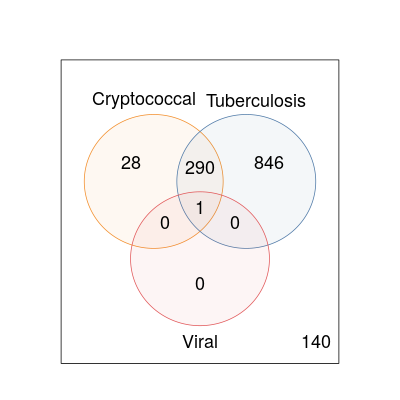

In [31]:
%%R -h 400 -w 400
venn_abundance(raw_protein_matrix, by_condition, percentage=F)

As expected (because of the reduction of importance of the few highly abundant proteins) the use of log-transformed (and trimmed) matrix resulted in highlighting more proteins changed in cryptococcal and viral meningitis - many of which appear to be shared with TB meningitis.

#### Proteins with increased/decreased abundance only:

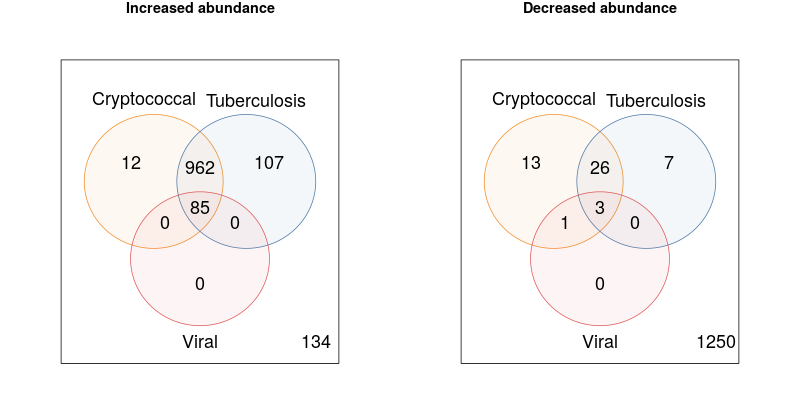

In [32]:
%%R -w 800 -h 400
par(mfrow=c(1, 2))
venn_abundance(protein_matrix, by_condition, include='up', main='Increased abundance')
venn_abundance(protein_matrix, by_condition, include='down', main='Decreased abundance')

Discussion:
 - the fact that more proteins has increased rather than decreased abundance might have been expected: introduction of a virus, bacteria or fungus should trigger an action of the immune system (which means that we expect more immune response-related proteins, more contents of lysed cells, and maybe even some proteins of the pathogen cross-reacting with SOMAScan aptamers)
  - cryptococcocal and tuberculosis have more similar protein abundance profiles than any of these have to viral meningitis.
  - levels of ~7% of proteins are significantly changed across all the conditions - I expect these to overlap with/be candidates for general biomarkers for meningitis

### Sanity check: using all conditions data (with contrasts) vs preselecting samples

On the example of tuberculosis I will compare my design matrix to a simpler method of preselecting the conditions (which results in exclusion of other samples and omission of their information in Bayesian priors) in order to cross-check if these (and contrasts) are set-up properly.

In [33]:
%%R
diff_ebayes <- function(a, b, ...){
    fit = limma_protein_fit(a=a, b=b, ...)
    limma::eBayes(fit, trend=T, robust=T)
}

full_table <- function(e_bayes_result, coef=1){    
    table = limma::topTable(e_bayes_result, coef=coef, number=Inf)
    table$protein = rownames(table)
    table
}

Here, I use data from all patients to for the Bayesian model:

In [34]:
%%R -o tb_all_proteins
result = diff_ebayes('Tuberculosis', 'Healthy control')
tb_all_proteins = full_table(result)

In [35]:
tb_all_proteins.to_csv(path + 'tbm.csv')
tb_all_proteins.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,protein
Proteinase-3,2.671754,3.365157,15.080238,1.639416e-25,2.131241e-22,47.626959,Proteinase-3
Myeloperoxidase,2.803410,3.511722,14.829820,4.543220e-25,2.953093e-22,46.618247,Myeloperoxidase
H2B2E,2.176113,3.825534,14.611192,1.113436e-24,3.122867e-22,45.730916,H2B2E
HSP 90b,1.345751,4.522989,14.596533,1.182666e-24,3.122867e-22,45.671199,HSP 90b
GRN,0.924096,4.521503,14.592775,1.201103e-24,3.122867e-22,45.655884,GRN


and check whether simpler model (limited to the tuberculosis and healthy patients altogether) yields comparable results:

In [36]:
%%R -o tb_simple
result = diff_ebayes('Tuberculosis', 'Healthy control', use_all=F)
tb_simple = limma::topTable(result, coef=2)

In [37]:
tb_simple.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
Myeloperoxidase,2.803410,3.284701,18.494436,3.927863e-25,5.106221e-22,46.993057
Proteinase-3,2.671754,3.116973,17.591425,4.080984e-24,2.652640e-21,44.679085
hnRNP A2/B1,2.008522,3.673813,16.672399,4.830408e-23,2.093177e-20,42.231580
HSP 90b,1.345751,4.420243,16.555953,6.650393e-23,2.161378e-20,41.914577
H2B2E,2.176113,3.682985,16.299764,1.351111e-22,2.950363e-20,41.211570


The results are indeed comparable. I will continue using the former model which benefits the conditions with lower number of patients providing additional estimates of variability of  protein abundances.

### Comparison to non-transformed matrix

Finally I disable the log transformation to see how much the results would change:

In [38]:
%%R -o tb_all_proteins_raw
result = diff_ebayes('Tuberculosis', 'Healthy control', data=raw_protein_matrix)
tb_all_proteins_raw = full_table(result)

In [39]:
tb_all_proteins_raw.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,protein
Lysozyme,61798.203538,67997.262195,12.342224,3.414236e-20,4.455578e-17,-4.254329,Lysozyme
TIMP-1,65320.261538,89128.779268,11.827487,3.121111e-19,2.036525e-16,-4.264678,TIMP-1
IGFBP-4,104840.016000,186800.742683,11.561933,9.882769e-19,4.299004e-16,-4.270296,IGFBP-4
C3d,124850.490462,99248.919512,11.434943,1.719287e-18,5.609172e-16,-4.273051,C3d
Cyclophilin A,130136.757538,117191.286585,11.150718,5.970601e-18,1.558327e-15,-4.279385,Cyclophilin A


In [40]:
l = tb_all_proteins[tb_all_proteins['adj.P.Val'] < 0.05]
r = tb_all_proteins_raw[tb_all_proteins_raw['adj.P.Val'] < 0.05]

from helpers.presentation import compare_sets
compare_sets(l.protein, r.protein, percentage=True)

Or when relative to all analyzed proteins:

In [41]:
percent_of_proteins = lambda n: f'{n / len(protein_matrix) * 100:.2f}%'

In [42]:
percent_of_proteins(65), percent_of_proteins(12)

('5.00%', '0.92%')

The differences are small as abundances of most of the proteins are significantly changed:

In [43]:
percent_of_proteins(len(l)), percent_of_proteins(len(r))

('91.54%', '87.46%')

In other words, the effect is visible regardless of the way we transform the data.

#### Discussion:

[(Li et al, 2006)](https://ieeexplore.ieee.org/document/4030607)* shows that many (20-40%) genes claimed to be significant may differ between the results of differential expression analysis using log-transformed and non-transformed data (so that these genes are highlighted by one but not the other analysis). This is not as apparent in this study for TB-HC contrast.

Log-transform stabilizes variance, preserves ordering, and crucially reduces impact of the outliers (Li et al, 2006). While it was reported that the top differentially expressed genes of the micro-array experiments do not change greatly when the log-transform is applied (Li et al, 2006), in the TB-HC contrast the top results vary markedly:

In [44]:
from helpers.stats import (
    # significant as l an r are pre-filtered to be signigficant only
    results_correlation as significant_results_correlation
    # this uses Spearman correlation by default
)

significant_results_correlation(l, r, n=10)

SpearmanrResult(correlation=0.3569653238400649, pvalue=0.3112625747973301)

However, overall the order of the DE proteins deemed to be significant is correlated:

In [45]:
significant_results_correlation(l, r)

SpearmanrResult(correlation=0.6056730809286227, pvalue=1.391909347660327e-113)

In [46]:
from plots.annotations import conditions_names, tuberculosis_status

In [47]:
patient_annotations = DataFrame({
    'Meningitis': clinical.condition.replace(conditions_names),
    'Tuberculosis status': clinical.condition.map(tuberculosis_status).fillna('-'),
    'HIV status': clinical.HIVResult
})

In [48]:
top_by_method = concat([
    tb_all_proteins.head().assign(Transform='log'),
    tb_all_proteins_raw.head().assign(Transform='none')
])

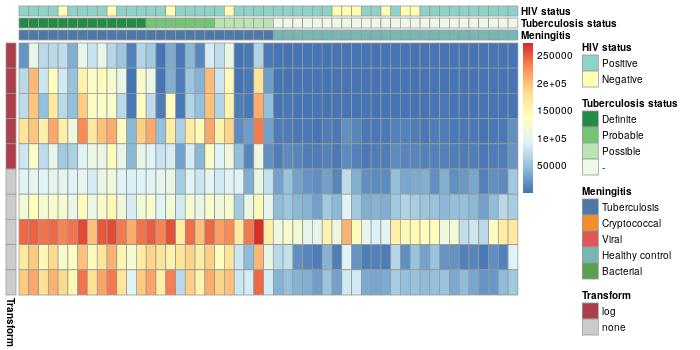

In [49]:
%%R -w 700 -h 350 -u px -i patient_annotations -i top_by_method

colnames(raw_protein_matrix) <- sub('^X', '', colnames(raw_protein_matrix))
rownames(patient_annotations) <- colnames(raw_protein_matrix)
names(patient_annotations) <- sub('\\.', ' ', names(patient_annotations))
patient_colors$Transform = c('log'='#ac3f4a', 'none'='#cccccc')

data = raw_protein_matrix[top_by_method$protein,by_condition == 'Tuberculosis' | by_condition == 'Healthy control']

compare_transforms = function(data) {
    pheatmap::pheatmap(
        data,
        show_colnames=F, show_rownames=F,
        annotation_col=patient_annotations,
        annotation_colors=patient_colors,
        annotation_row=top_by_method[,'Transform', drop=F],
        cluster_rows=F, cluster_cols=F
    )
}
compare_transforms(data)

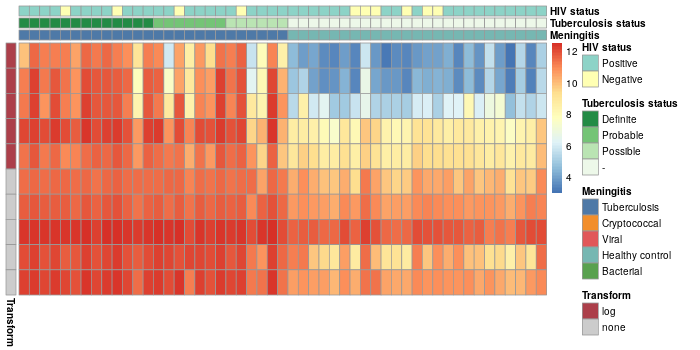

In [50]:
%%R -w 700 -h 350 -u px
compare_transforms(log(data))

#### Conclusions:
 - the two objectives are ultimately just... different.
 - as highlighted by the Venn diagrams, log transformed data yields more significant findings for the group other than TBM
 - some proteins highlighted when using the log-transformed data appear to correlate (slightly/sometimes) with the TB status (definite/probable/possible)
 - I will stick to the more robust, log-transformed data, however I will also report the top 10 proteins for non-transformed data as these compliment the picture

### Volcano plots

In [51]:
%%R
library(ggplot2)
source('plots/volcano.R')

Important: as the data are high contrast and high dynamic range I decided to use log(10). This means that each increase on logFC axis by one corresponds to an increase of the fold change by an order of magnitude.

#### Final look on the transformation effect

In [52]:
tb_by_transform = concat([
    tb_all_proteins.assign(transform='log'),
    tb_all_proteins_raw.assign(transform='none')
])

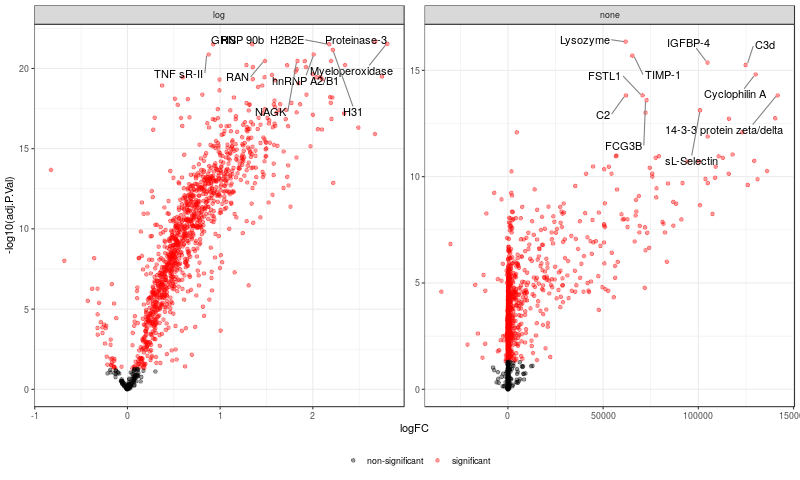

In [53]:
%%R -i tb_by_transform -w 800
volcano_plot(tb_by_transform, n=10, facet='transform', scale='free')

TODO: Think about the scale of fold change

As shown above, without the log-transform the fold changes are squeezed around zero.

### Tuberculosis

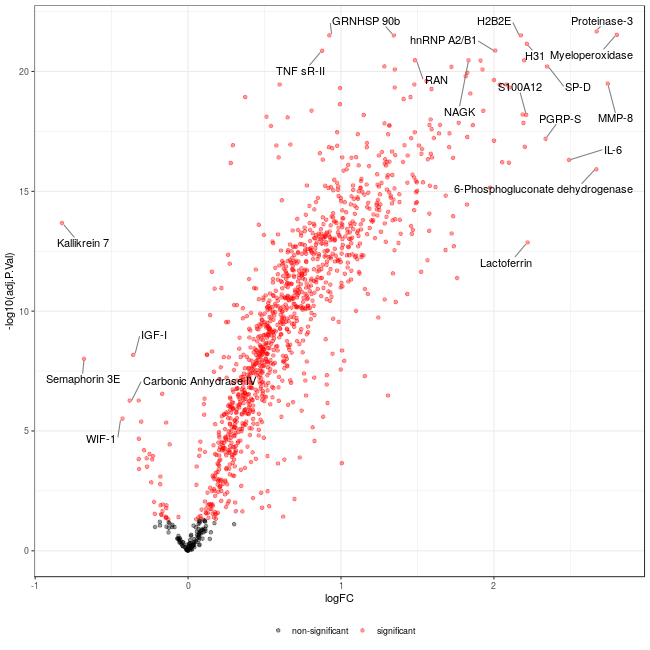

In [54]:
%%R -w 650 -h 650
select_most_significant_some_reduced_and_more_increased = function(data, n){
    reduced_abundance = data[data$logFC < 0,]
    increased_abundance = data[data$logFC > 0,]
    unique(rbind(
        head(reduced_abundance[order(reduced_abundance$logFC),], 5),
        head(increased_abundance[order(-increased_abundance$logFC),], 10),
        select_n_most_significant(data, 10)
    ))
}

volcano_plot(tb_all_proteins, select=select_most_significant_some_reduced_and_more_increased)

### Cryptoccocal

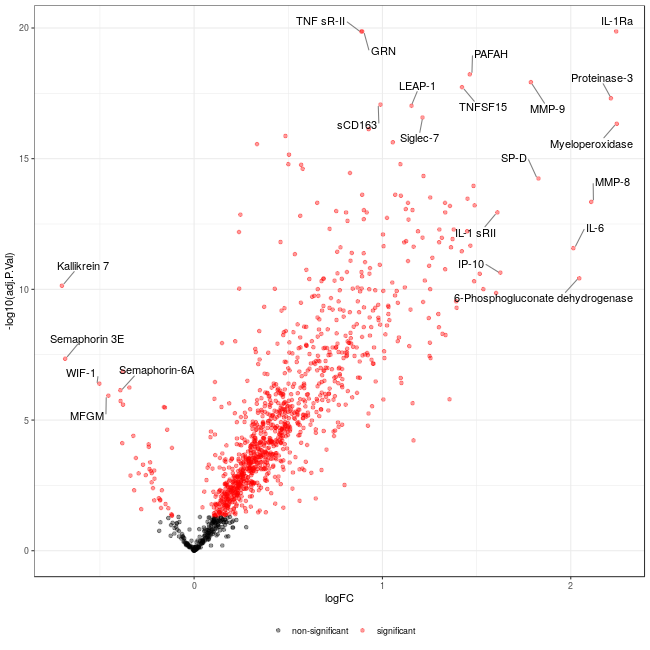

In [55]:
%%R -w 650 -h 650 -o crypto_all_proteins
result = diff_ebayes('Cryptococcal', 'Healthy control')
crypto_all_proteins = full_table(result)
volcano_plot(crypto_all_proteins, select=select_most_significant_some_reduced_and_more_increased)

In [56]:
crypto_all_proteins.to_csv(path + 'crypto.csv')
crypto_all_proteins.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,protein
TNF sR-II,0.887916,4.755464,14.021439,1.287771e-23,1.357994e-20,43.294414,TNF sR-II
GRN,0.892402,4.521503,13.812972,3.091386e-23,1.357994e-20,42.430857,GRN
IL-1Ra,2.241137,3.572167,13.809735,3.133833e-23,1.357994e-20,42.417407,IL-1Ra
PAFAH,1.463908,3.745695,12.856990,1.834343e-21,5.961614e-19,38.401288,PAFAH
MMP-9,1.788176,4.181339,12.647792,4.547338e-21,1.182308e-18,37.504783,MMP-9


### Viral

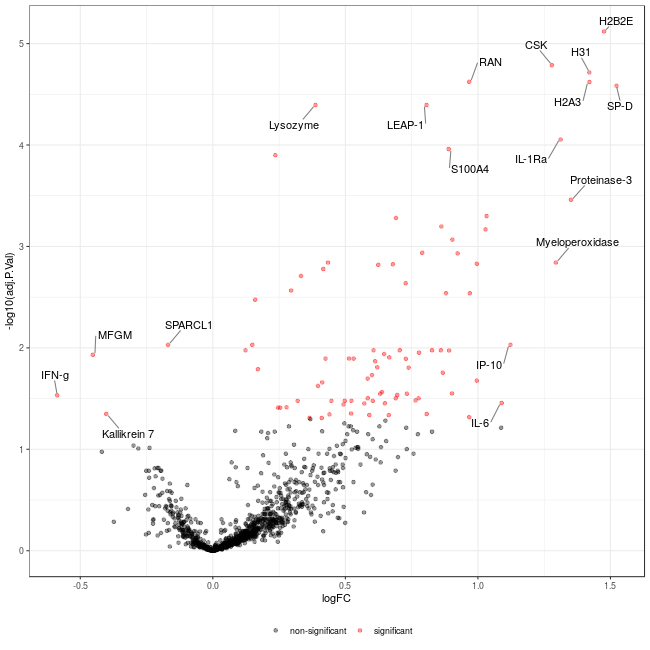

In [57]:
%%R -w 650 -h 650 -o viral_all_proteins
result = diff_ebayes('Viral', 'Healthy control')
viral_all_proteins = full_table(result)
volcano_plot(viral_all_proteins, select=select_most_significant_some_reduced_and_more_increased)

In [58]:
viral_all_proteins.to_csv(path + 'viral.csv')
viral_all_proteins.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,protein
H2B2E,1.475846,3.825534,6.491092,5.836378e-09,0.000008,10.264197,H2B2E
CSK,1.279060,2.730792,6.156922,2.513386e-08,0.000016,8.883794,CSK
H31,1.419917,3.213476,6.024850,4.445221e-08,0.000019,8.345074,H31
RAN,0.967010,2.616975,5.908258,7.327547e-08,0.000024,7.873068,RAN
H2A3,1.420431,3.444940,5.854950,9.198161e-08,0.000024,7.658428,H2A3


## Power simulation

Is the lower number of proteins deemed significant in the viral-healthy controls analysis a result of low power due to low number of samples (7) vs more (24, 26) samples in crypto and TB groups?

In [59]:
by_condition.value_counts()

Tuberculosis       26
Healthy control    25
Cryptococcal       24
Viral               7
Name: Meningitis, dtype: int64

In [60]:
significant_in_viral = sum(viral_all_proteins['adj.P.Val'] < 0.05)
significant_in_viral

89

In [61]:
significant_in_tb = sum(tb_all_proteins['adj.P.Val'] < 0.05)
significant_in_tb

1190

There are two ways to perform this simulation:
- randomly sub-sample on of the more numerous groups (TB or crypto) and remove remaining samples completely, which changes the variation estimates used by limma (which is both bad - as it changes the experimental assumptions - and good - as the viral group indeed provides less input to the variance estimates)
- modify the design matrix effectively sub-sampling one of the groups, but keeping the variance estimates unaffected

In [62]:
%%R
list_of_columns = function(x) {
    # CC-BY-3.0 Tommy, https://stackoverflow.com/a/6821395/6646912
    lapply(seq_len(ncol(x)), function(i) x[,i])
}

In [63]:
%%R -i significant_in_viral

patients_with_viral = 7

patients = names(by_condition[by_condition == 'Tuberculosis'])
patient_combinations = list_of_columns(combn(patients, patients_with_viral))

length(patient_combinations)

[1] 657800


In [64]:
%%R
count_significant_genes_for = function(patients, condition, discard_other_samples=F) {
    subset_name = paste0(condition, '_subset')
    by_condition[patients] = subset_name
    
    if(discard_other_samples == T) {
        protein_matrix = protein_matrix[by_condition != condition]
        by_condition = by_condition[by_condition != condition]
    }
    
    fit = limma_fit(data=protein_matrix, conditions_vector=by_condition, a=subset_name, b='Healthy control')
    fit = limma::eBayes(fit, trend=T, robust=T)
    table = full_table(fit)
    sum(table$adj.P.Val < 0.05)
}

use_x_percent = 1
n = round(length(patient_combinations) * use_x_percent / 100)
n

[1] 6578


Takes about a minute!

In [65]:
%%R
# pbmcapply::pbmclapply ?
singificant_proteins_sub_sampled_tb = parallel::mclapply(
    sample(patient_combinations, size=n, replace=F),
    count_significant_genes_for,
    condition='Tuberculosis',
    discard_other_samples=F
)

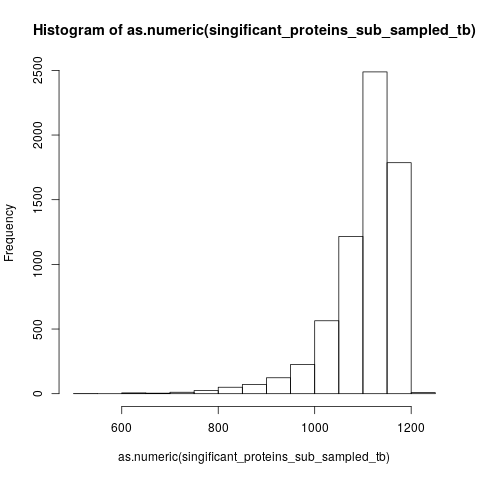

In [66]:
%%R
hist(as.numeric(singificant_proteins_sub_sampled_tb))

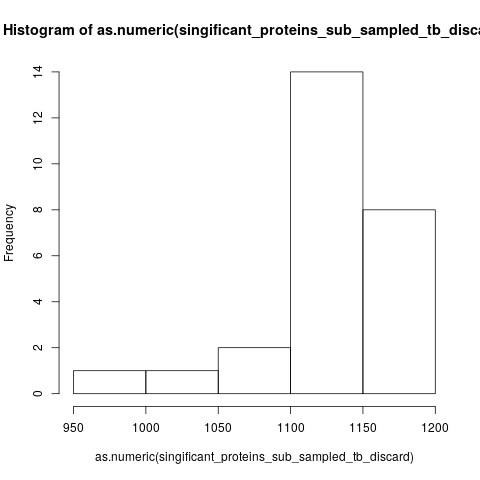

In [67]:
%%R
singificant_proteins_sub_sampled_tb_discard = parallel::mclapply(
    sample(patient_combinations, size=26, replace=F),
    count_significant_genes_for,
    condition='Tuberculosis',
    discard_other_samples=T
)
hist(as.numeric(singificant_proteins_sub_sampled_tb_discard))

It seems that this the low number of changed proteins detected viral is not a power thing...

## Pairwise comparisons

### Tuberculosis vs cryptoccocal

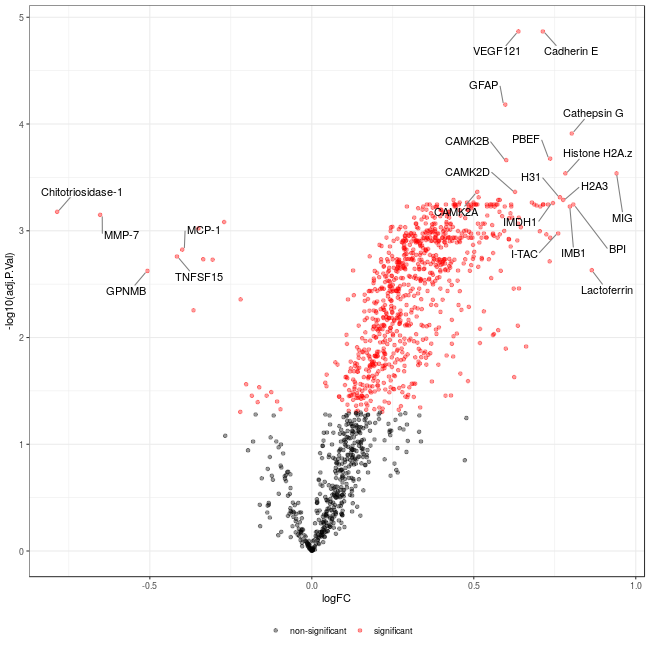

In [68]:
%%R -w 650 -h 650 -o tb_vs_crypto_proteins
result = diff_ebayes('Tuberculosis', 'Cryptococcal')
tb_vs_crypto_proteins = full_table(result)
volcano_plot(tb_vs_crypto_proteins, select=select_most_significant_some_reduced_and_more_increased)

### Tuberculosis vs viral

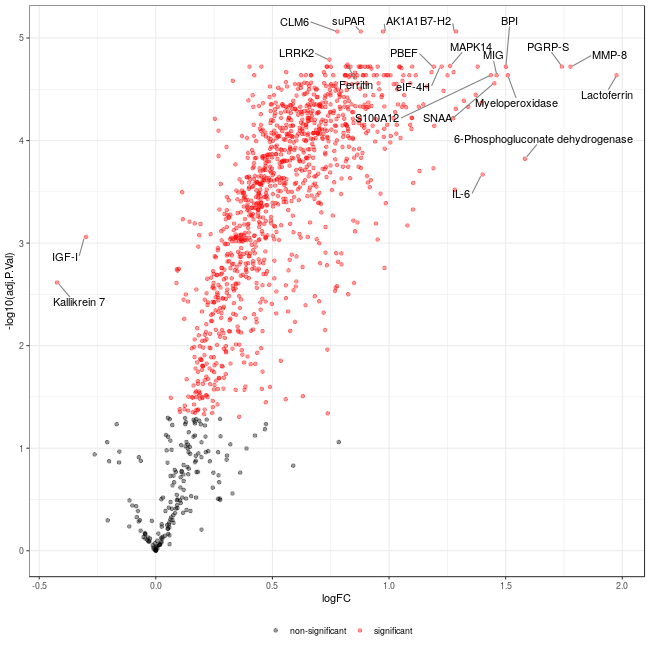

In [69]:
%%R -w 650 -h 650 -o tb_vs_viral_proteins
result = diff_ebayes('Tuberculosis', 'Viral')
tb_vs_viral_proteins = full_table(result)
volcano_plot(tb_vs_viral_proteins, select=select_most_significant_some_reduced_and_more_increased)

### Viral vs cryptoccocal

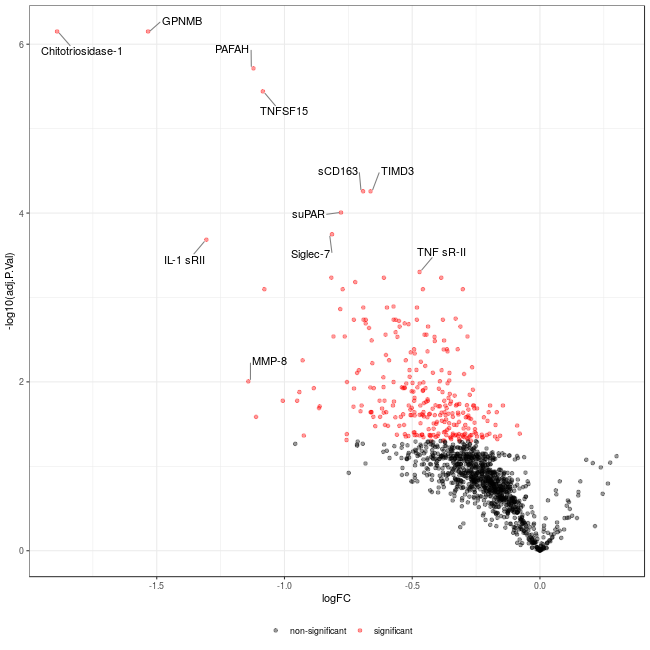

In [70]:
%%R -w 650 -h 650 -o viral_vs_crypto_proteins
result = diff_ebayes('Viral', 'Cryptococcal')
viral_vs_crypto_proteins = full_table(result)
volcano_plot(viral_vs_crypto_proteins, select=select_most_significant_some_reduced_and_more_increased)

### Summary of the most significant findings

Or ranking of proteins which are significantly changed when contrasting with both conditions:

In [71]:
from scipy.stats import combine_pvalues
from copy import deepcopy

def up_in(table):
    return table
    
def down_in(table):
    table = deepcopy(table)
    table['logFC'] = -table['logFC']
    return table

def same_sign(a, b):
    return ((a > 0) & (b > 0)) | ((a < 0) & (b < 0))

def overlap(a, b, suffixes=('.x', '.y')):
    o = list(a.protein)
    df = a.loc[o].join(b.loc[o], lsuffix=suffixes[0], rsuffix=suffixes[1])
    for to_drop in ['P.Value', 'protein', 't', 'B']:
        df = df.drop([to_drop + suffixes[0], to_drop + suffixes[1]], axis=1)
    df = df[
        same_sign(df['logFC' + suffixes[0]], df['logFC' + suffixes[1]])
    ]
    df['combined_p'] = df.apply(lambda row:
        combine_pvalues(
            [
                row['adj.P.Val' + suffixes[0]],
                row['adj.P.Val' + suffixes[1]]
            ],
        method='fisher')[1],
        axis=1
    )
    df['average_fold_change'] = (df['logFC' + suffixes[0]] + df['logFC' + suffixes[1]]) / 2
    return df.sort_values('combined_p')

In [72]:
characteristic_for = {
    'tb': overlap(
        up_in(tb_vs_crypto_proteins),
        up_in(tb_vs_viral_proteins)
    ),
    'viral': overlap(
        up_in(viral_vs_crypto_proteins),
        down_in(tb_vs_viral_proteins)
    ),
    'crypto': overlap(
        down_in(viral_vs_crypto_proteins),
        down_in(tb_vs_crypto_proteins)
    )
}

In [73]:
characteristic_for['tb'].head(n=10)

,logFC.x,AveExpr.x,adj.P.Val.x,logFC.y,AveExpr.y,adj.P.Val.y,combined_p,average_fold_change
VEGF121,0.637860,1.640027,0.000014,0.816303,1.640027,0.000023,7.175608e-09,0.727081
Cadherin E,0.713030,2.732817,0.000014,0.802851,2.732817,0.000056,1.679814e-08,0.757940
GFAP,0.597169,2.972483,0.000066,0.881148,2.972483,0.000019,2.689585e-08,0.739159
Cathepsin G,0.802536,2.120671,0.000123,1.182422,2.120671,0.000022,5.484229e-08,0.992479
PBEF,0.735782,2.094988,0.000211,1.191843,2.094988,0.000019,8.158590e-08,0.963812
MIG,0.940697,2.651938,0.000290,1.461298,2.651938,0.000023,1.327390e-07,1.200998
B7-H2,0.559428,3.455760,0.001059,1.287239,3.455760,0.000009,1.784208e-07,0.923334
SLPI,0.437442,3.461472,0.000515,0.750377,3.461472,0.000019,1.906086e-07,0.593909
Elastase,0.492856,1.832081,0.000567,0.918418,1.832081,0.000019,2.087003e-07,0.705637
Azurocidin,0.569540,1.582518,0.000567,1.043447,1.582518,0.000019,2.090623e-07,0.806493


note: SOMALogic filed a [patent for TB biomarkers](https://patents.google.com/patent/WO2013155460A1). We have some overlap with their list, though I did not check if it is significant.

In [74]:
characteristic_for['viral'].head(n=10)

,logFC.x,AveExpr.x,adj.P.Val.x,logFC.y,AveExpr.y,adj.P.Val.y,combined_p,average_fold_change
GPNMB,-1.533789,3.213937,7.061906e-07,-1.026358,3.213937,0.000053,9.322970e-10,-1.280074
PAFAH,-1.121392,3.745695,1.932706e-06,-0.924590,3.745695,0.000020,9.597960e-10,-1.022991
Chitotriosidase-1,-1.889979,3.650868,7.061906e-07,-1.103792,3.650868,0.000259,4.288156e-09,-1.496885
suPAR,-0.778947,3.649027,9.862233e-05,-0.878787,3.649027,0.000009,1.863959e-08,-0.828867
TNFSF15,-1.084656,3.146139,3.621286e-06,-0.668325,3.146139,0.000344,2.675718e-08,-0.876491
sCD163,-0.692456,4.110913,5.528293e-05,-0.623515,4.110913,0.000029,3.357930e-08,-0.657986
IL-1 sRII,-1.305722,3.721479,2.071009e-04,-1.380099,3.721479,0.000019,8.030993e-08,-1.342911
TIMD3,-0.663140,3.398645,5.528293e-05,-0.533540,3.398645,0.000075,8.439010e-08,-0.598340
CLM6,-0.610674,4.085140,5.834696e-04,-0.778553,4.085140,0.000009,1.013175e-07,-0.694613
Siglec-7,-0.813997,3.456246,1.784007e-04,-0.770468,3.456246,0.000033,1.162703e-07,-0.792233


In [75]:
characteristic_for['crypto'].head(n=10)

,logFC.x,AveExpr.x,adj.P.Val.x,logFC.y,AveExpr.y,adj.P.Val.y,combined_p,average_fold_change
Chitotriosidase-1,1.889979,3.650868,7.061906e-07,0.786187,3.650868,0.000664,1.054459e-08,1.338083
GPNMB,1.533789,3.213937,7.061906e-07,0.507431,3.213937,0.002377,3.559093e-08,1.020610
TNFSF15,1.084656,3.146139,3.621286e-06,0.416331,3.146139,0.001742,1.254027e-07,0.750494
PAFAH,1.121392,3.745695,1.932706e-06,0.196802,3.745695,0.113967,3.596591e-06,0.659097
MMP-7,1.078643,2.595623,7.983115e-04,0.653563,2.595623,0.000709,8.710428e-06,0.866103
TrATPase,0.564624,3.238280,1.835173e-03,0.350017,3.238280,0.000949,2.484742e-05,0.457321
TIMD3,0.663140,3.398645,5.528293e-05,0.129600,3.398645,0.131605,9.335230e-05,0.396370
MCP-1,0.572848,2.191699,1.004243e-02,0.399973,2.191699,0.001501,1.824387e-04,0.486410
Osteopontin,0.386207,4.540895,5.834696e-04,0.125007,4.540895,0.032464,2.249161e-04,0.255607
sCD163,0.692456,4.110913,5.528293e-05,0.068941,4.110913,0.446315,2.864548e-04,0.380699


In [76]:
characteristic_for_joined = concat(
    [df.assign(meningitis=name) for name, df in characteristic_for.items()]
).rename(columns={'combined_p': 'adj.P.Val', 'average_fold_change': 'logFC'})
characteristic_for_joined['protein'] = characteristic_for_joined.index

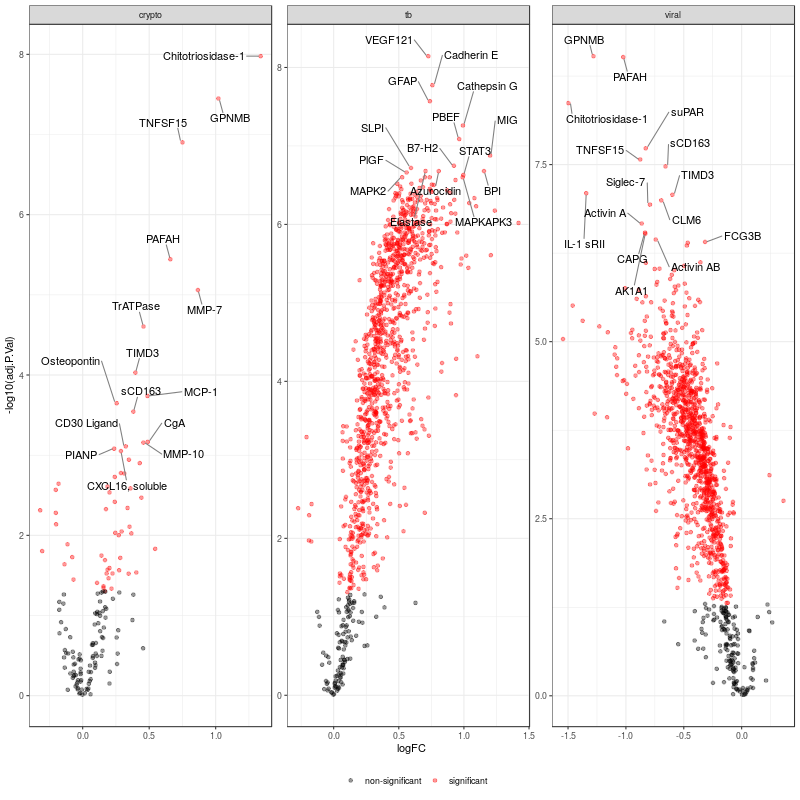

In [77]:
%%R -w 800 -h 800 -i characteristic_for_joined

volcano_plot(characteristic_for_joined, facet='meningitis', scale='free')

This is different from making a contrast which juxtaposes e.g. TB with Viral and Crypto, as this specifically looks for proteins which are high in one condition and low in the remaining two.

Fun fact: when looking for a quick way to verify if these work as biomarkers, I found this study: [Identification of potential metabolic biomarkers of cerebrospinal fluids that differentiate tuberculous meningitis from other types of meningitis by a metabolomics study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5725005/).
- they not only have the same patient groups, but also use almost exact same colors that I assigned (tb=blue, cm=orange)!
- they used OPLS-DA!
- on mass spectroscopy data, which nicely compliments this project

## ORA

In [78]:
relevant_aptamers = read_csv('data/other/relevant_aptamers.csv')

In [79]:
def uniprot_query(top, n=None, significant_only=True):
    chosen = top[top['adj.P.Val'] < 0.05]
    if n:
        chosen = chosen.head(n)
    chosen = chosen.index
    metadata = relevant_aptamers[relevant_aptamers.Target.isin(chosen)]
    return list(metadata.UniProt.apply(
        lambda x: x.split(' ')[0] # take the first isoform only
    ))

def show_uniprot_query(top, n=10):
    print('\n'.join(uniprot_query(top, n)))

In [80]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)

### Tuberculosis

In [81]:
tb_terms = gp.profile(organism='hsapiens', query=uniprot_query(tb_all_proteins, n=50), ordered=T)
tb_terms.head()

,source,native,name,p_value,significant,...,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0070062,extracellular exosome,2.820644e-18,True,...,18745,0.750000,0.014078,query_1,"[GO:1903561, GO:0005615]"
1,GO:CC,GO:1903561,extracellular vesicle,3.797866e-18,True,...,18745,0.750000,0.013934,query_1,"[GO:0031982, GO:0043230]"
2,GO:CC,GO:0043230,extracellular organelle,3.901352e-18,True,...,18745,0.750000,0.013921,query_1,"[GO:0044421, GO:0043226]"
3,GO:CC,GO:0005615,extracellular space,3.879961e-17,True,...,18745,0.791667,0.010876,query_1,[GO:0044421]
4,GO:CC,GO:0031982,vesicle,5.613311e-17,True,...,18745,0.812500,0.010234,query_1,[GO:0043227]


### Viral

In [82]:
viral_terms = gp.profile(organism='hsapiens', query=uniprot_query(viral_all_proteins, n=50), ordered=T)
viral_terms.head()

,source,native,name,p_value,significant,...,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0005615,extracellular space,3.879961e-17,True,...,18745,0.791667,0.010876,query_1,[GO:0044421]
1,GO:CC,GO:0044421,extracellular region part,2.681111e-16,True,...,18745,0.850000,0.009204,query_1,"[GO:0005576, GO:0005575]"
2,GO:CC,GO:0070062,extracellular exosome,7.084749e-16,True,...,18745,0.645833,0.014547,query_1,"[GO:1903561, GO:0005615]"
3,GO:CC,GO:1903561,extracellular vesicle,9.553390e-16,True,...,18745,0.645833,0.014399,query_1,"[GO:0031982, GO:0043230]"
4,GO:CC,GO:0043230,extracellular organelle,9.814966e-16,True,...,18745,0.645833,0.014385,query_1,"[GO:0044421, GO:0043226]"


### Cryptococal

In [83]:
crypto_terms = gp.profile(organism='hsapiens', query=uniprot_query(crypto_all_proteins, n=50), ordered=T)
crypto_terms.head()

,source,native,name,p_value,significant,...,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0005576,extracellular region,2.255359e-17,True,...,18745,0.857143,0.009385,query_1,[GO:0005575]
1,GO:CC,GO:0005615,extracellular space,1.359088e-16,True,...,18745,0.775510,0.010876,query_1,[GO:0044421]
2,GO:BP,GO:0006955,immune response,9.020445e-16,True,...,17622,0.673469,0.015103,query_1,"[GO:0002376, GO:0050896]"
3,GO:CC,GO:0044421,extracellular region part,9.900197e-16,True,...,18745,0.775510,0.010287,query_1,"[GO:0005576, GO:0005575]"
4,GO:CC,GO:0031982,vesicle,2.997529e-15,True,...,18745,0.775510,0.009971,query_1,[GO:0043227]


### TB vs crypto?

In [84]:
gp.profile(organism='hsapiens', query=uniprot_query(tb_vs_crypto_proteins, n=50), ordered=T).head()

,source,native,name,p_value,significant,...,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0005576,extracellular region,7.065259e-10,True,...,18745,0.714286,0.007821,query_1,[GO:0005575]
1,GO:CC,GO:0031982,vesicle,2.829568e-09,True,...,18745,0.653061,0.008397,query_1,[GO:0043227]
2,GO:CC,GO:0044421,extracellular region part,8.720687e-09,True,...,18745,0.632653,0.008392,query_1,"[GO:0005576, GO:0005575]"
3,GO:CC,GO:0005615,extracellular space,1.406804e-08,True,...,18745,0.612245,0.008586,query_1,[GO:0044421]
4,GO:CC,GO:0070062,extracellular exosome,1.896488e-08,True,...,18745,0.489796,0.011262,query_1,"[GO:1903561, GO:0005615]"


It seems to me that this is not the way forward...

## Gene set enrichment

TBD

## Pathway plot

TBD

## Caveats of SOMAScan

A quick notes from [(Joshi and Mayr, 2018)](https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.118.036823):
- non specificity, cross-reactivity a known problem
- SNPs a known problem too
- PTMs(!) a potential problem (IMO more than SNPs), an important consideration for signaling proteins and signaling pathways - these may be under represented!

**Thus: (!!)**
Cross checking with RNA-seq is crucial and may hint us not only about the biological differences (i.e. SOMAScan detecting protein previously expressed and folded, while RNA-seq detecting proteins being actively expressed) but also about the discrepancies arising from failing SOMAScan failing to detect PTM modified signaling proteins or proteins bearing an important (and conformation changing) SNP.